# Exploratory Data Analysis - Amazon Reviews Dataset

In [6]:
# Setup
# -----------------------------------

# Standard library
import re
from collections import Counter
from pathlib import Path

# Third-party libraries
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2

# Local modules
from dataset_loader import load_dataset_amazon
from tmp import create_tmp


# Reset pyplot
plt.clf()
plt.close('all')
plt.style.use("dark_background")

# Create tmp folder
create_tmp()

# Select Dataset
dataset_file = "test.csv"
#dataset_file = "train.csv"
text_full = True

# Load Dataset
df = load_dataset_amazon(dataset_file, text_full)
print(f"Size of {dataset_file} dataset: {df.size}")

Recreated directory: /home/user/Documents/sentimentml/tmp
Dataset already downloaded. Reusing cached version at /home/user/Documents/sentimentml/datasets/kritanjalijain/amazon-reviews/versions/2
Size of test.csv dataset: 2000000


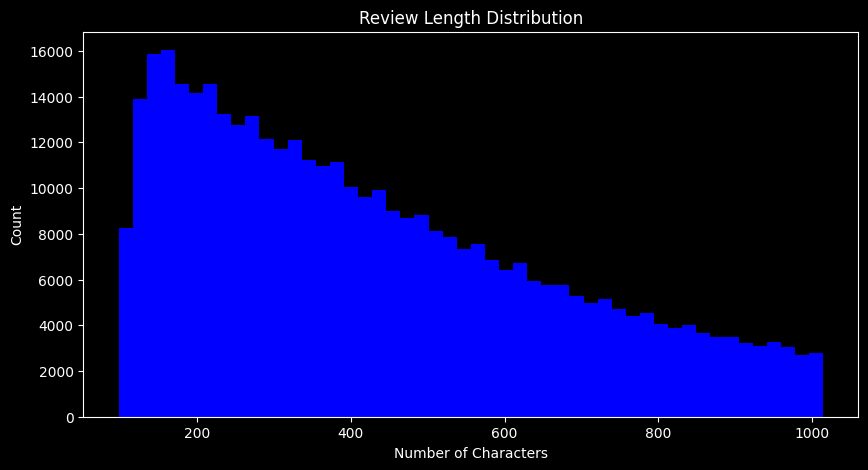

In [7]:
# EDA: Review Length Distribution
# -----------------------------------

plt.figure(figsize=(10,5))
plt.hist(df["length"], bins=50, color="blue")
plt.title("Review Length Distribution")
plt.xlabel("Number of Characters")
plt.ylabel("Count")
plt.show()

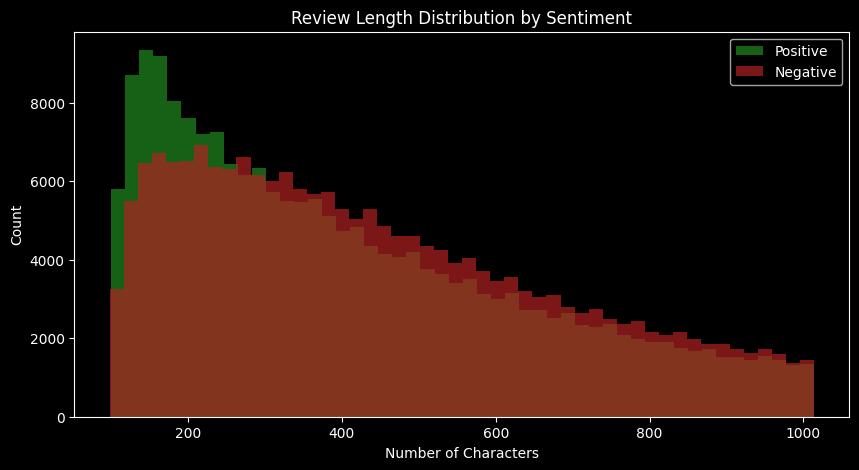

In [8]:
# EDA: Review Length Distribution by Sentiment
# -----------------------------------

# separate by class
pos = df[df["label"] == 2]["length"]
neg = df[df["label"] == 1]["length"]

# plot
plt.figure(figsize=(10,5))
plt.hist(pos, bins=50, alpha=0.7, color="forestgreen", label="Positive")
plt.hist(neg, bins=50, alpha=0.7, color="firebrick", label="Negative")
plt.xlabel("Number of Characters")
plt.ylabel("Count")
plt.title("Review Length Distribution by Sentiment")
plt.legend()
plt.show()

[nltk_data] Error loading stopwords: HTTP Error 429: Too Many Requests


Top 20 Words in Positive Reviews:
[('book', 113157), ('great', 93006), ('one', 74727), ('good', 66705), ('like', 53992), ('read', 45127), ('love', 39685), ('well', 38699), ('best', 35896), ('would', 35761), ('time', 34571), ('get', 32667), ('really', 32650), ('movie', 30766), ('first', 27310), ('album', 25994), ('much', 24971), ('also', 24148), ('story', 22163), ('use', 22151)]

Top 20 Words in Negative Reviews:
[('book', 105715), ('one', 78203), ('like', 60707), ('would', 58074), ('good', 48432), ('get', 44092), ('time', 40407), ('movie', 37008), ('even', 35462), ('read', 33166), ('buy', 32324), ('really', 31535), ('much', 31384), ('product', 31270), ('money', 31226), ('first', 29126), ('work', 27353), ('great', 26812), ('better', 26722), ('bad', 25979)]


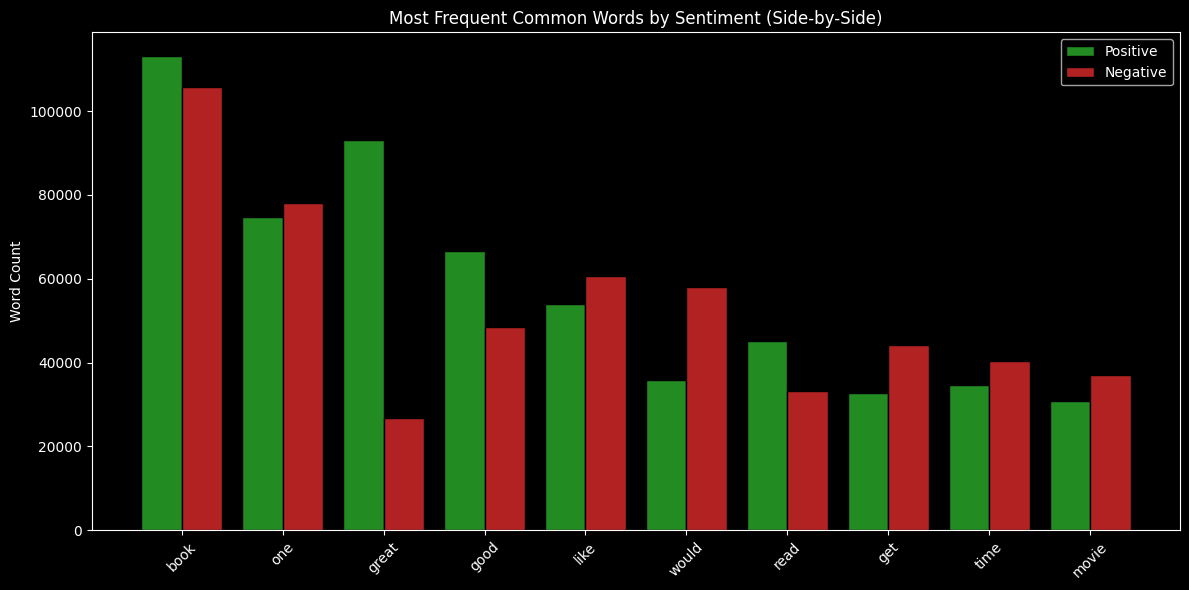

In [9]:
# EDA: Most Frequent Common Words by Sentiment 
# -----------------------------------

# Keep NLTK data inside the repo instead of the user directory
nltk_data_dir = Path.cwd() / "tmp" / "nltk_data"
nltk_data_dir.mkdir(parents=True, exist_ok=True)
nltk.data.path.insert(0, str(nltk_data_dir))

# Download stopwords if not already present
nltk.download("stopwords", download_dir=str(nltk_data_dir))

# Load English stopwords
stop = set(stopwords.words("english"))


def tokenize(text: str) -> list:
    # Convert to lowercase
    text = text.lower()

    # Remove non-alphabetic characters (numbers, punctuation, symbols)
    text = re.sub(r"[^a-z\s]", " ", text)

    # Split into tokens
    words = text.split()

    # Remove stopwords and very short tokens
    return [w for w in words if w not in stop and len(w) > 2]


# Extract words separately by sentiment class
pos_words = []
neg_words = []

# Accumulate tokens for positive reviews (label = 2)
for text in df[df["label"] == 2]["text_full"]:
    pos_words.extend(tokenize(text))

# Accumulate tokens for negative reviews (label = 1)
for text in df[df["label"] == 1]["text_full"]:
    neg_words.extend(tokenize(text))


# Count word frequencies (top 20 for each class)
top_pos = Counter(pos_words).most_common(20)
top_neg = Counter(neg_words).most_common(20)

print("Top 20 Words in Positive Reviews:")
print(top_pos)

print("\nTop 20 Words in Negative Reviews:")
print(top_neg)


# Build side-by-side bar chart

# Convert to dicts for easier lookup
pos_dict = dict(top_pos)
neg_dict = dict(top_neg)

# Use only words that appear in both top lists
common_words = list(set(pos_dict.keys()) & set(neg_dict.keys()))

# If there are many common words, keep only the most frequent ones overall (optional)
common_words.sort(key=lambda w: pos_dict[w] + neg_dict[w], reverse=True)
common_words = common_words[:10]  # top 10 common words

pos_counts = [pos_dict[w] for w in common_words]
neg_counts = [neg_dict[w] for w in common_words]

# Create side-by-side bar plot
x = range(len(common_words))

plt.figure(figsize=(12, 6))
plt.bar([i - 0.2 for i in x], pos_counts, width=0.4, label="Positive", edgecolor="black", color="forestgreen")
plt.bar([i + 0.2 for i in x], neg_counts, width=0.4, label="Negative", edgecolor="black", color="firebrick")



plt.xticks(list(x), common_words, rotation=45)
plt.ylabel("Word Count")
plt.title("Most Frequent Common Words by Sentiment (Side-by-Side)")
plt.legend()
plt.tight_layout()
plt.show()



Top positive words:
              score
book       0.034603
great      0.033552
good       0.023296
love       0.018034
read       0.017770
like       0.016378
best       0.015369
movie      0.014934
just       0.014060
cd         0.013469
really     0.012713
time       0.012379
album      0.011680
excellent  0.010138
music      0.010018
easy       0.010004
story      0.009953
little     0.009586
product    0.009452
use        0.009277

Top negative words:
            score
book     0.030539
just     0.018415
like     0.017912
don      0.016272
movie    0.016141
good     0.015080
money    0.014857
time     0.014044
product  0.013848
buy      0.013207
read     0.012083
bad      0.011954
work     0.011806
did      0.011637
really   0.011523
waste    0.011377
better   0.010633
bought   0.010268
didn     0.009703
use      0.009445


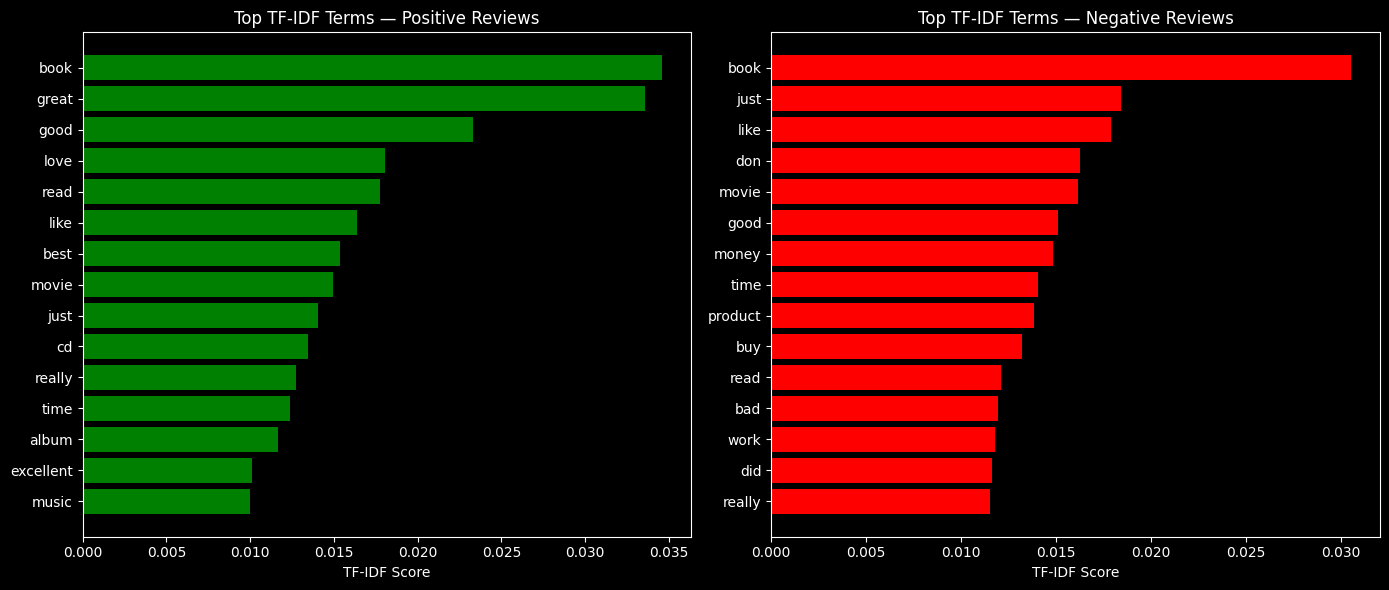

In [10]:
# EDA: Top TF-IDF terms by class
# -----------------------------------

# This analysis identifies the most discriminative words in positive vs negative reviews.
# Unlike raw frequency counts, TF‑IDF highlights terms that are unique to each sentiment class.

# Filter dataset by class
positive = df[df["label"] == 2]["text_full"]
negative = df[df["label"] == 1]["text_full"]

# Create TF-IDF vectorizer (unigrams only for now)
# min_df removes rare noise, max_df reduces extremely frequent neutral stopwords
vectorizer = TfidfVectorizer(
    max_df=0.85,
    min_df=5,
    stop_words="english"
)

# Fit on the entire dataset but transform per class
vectorizer.fit(df["text_full"])
pos_vec = vectorizer.transform(positive)
neg_vec = vectorizer.transform(negative)

# Convert to DataFrames for easier inspection
feature_names = vectorizer.get_feature_names_out()

pos_scores = pd.DataFrame(pos_vec.mean(axis=0).A1, index=feature_names, columns=["score"]) \
    .sort_values("score", ascending=False)

neg_scores = pd.DataFrame(neg_vec.mean(axis=0).A1, index=feature_names, columns=["score"]) \
    .sort_values("score", ascending=False)

print("\nTop positive words:")
print(pos_scores.head(20))

print("\nTop negative words:")
print(neg_scores.head(20))

top_n = 15

# Reverse order so bars go from highest (top) to lowest (bottom)
pos_plot_data = pos_scores.head(top_n).iloc[::-1]
neg_plot_data = neg_scores.head(top_n).iloc[::-1]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].barh(pos_plot_data.index, pos_plot_data.score, color="green")
axes[0].set_title("Top TF-IDF Terms — Positive Reviews")
axes[0].set_xlabel("TF-IDF Score")

axes[1].barh(neg_plot_data.index, neg_plot_data.score, color="red")
axes[1].set_title("Top TF-IDF Terms — Negative Reviews")
axes[1].set_xlabel("TF-IDF Score")

plt.tight_layout()
plt.show()


Top Positive Bigrams:
                       score
great book          0.003839
highly recommend    0.003825
read book           0.003771
year old            0.002705
great product       0.002609
works great         0.002542
good book           0.002388
book read           0.002245
years ago           0.002046
easy use            0.001992
recommend book      0.001982
book great          0.001964
highly recommended  0.001960
long time           0.001845
pretty good         0.001658
great price         0.001650
ve read             0.001645
great movie         0.001618
easy read           0.001615
really good         0.001606

Top Negative Bigrams:
                     score
waste money       0.006393
waste time        0.004051
don waste         0.004002
don buy           0.003404
save money        0.002967
read book         0.002398
don know          0.002286
year old          0.002084
poor quality      0.002078
does work         0.002011
doesn work        0.001978
time money        0.0

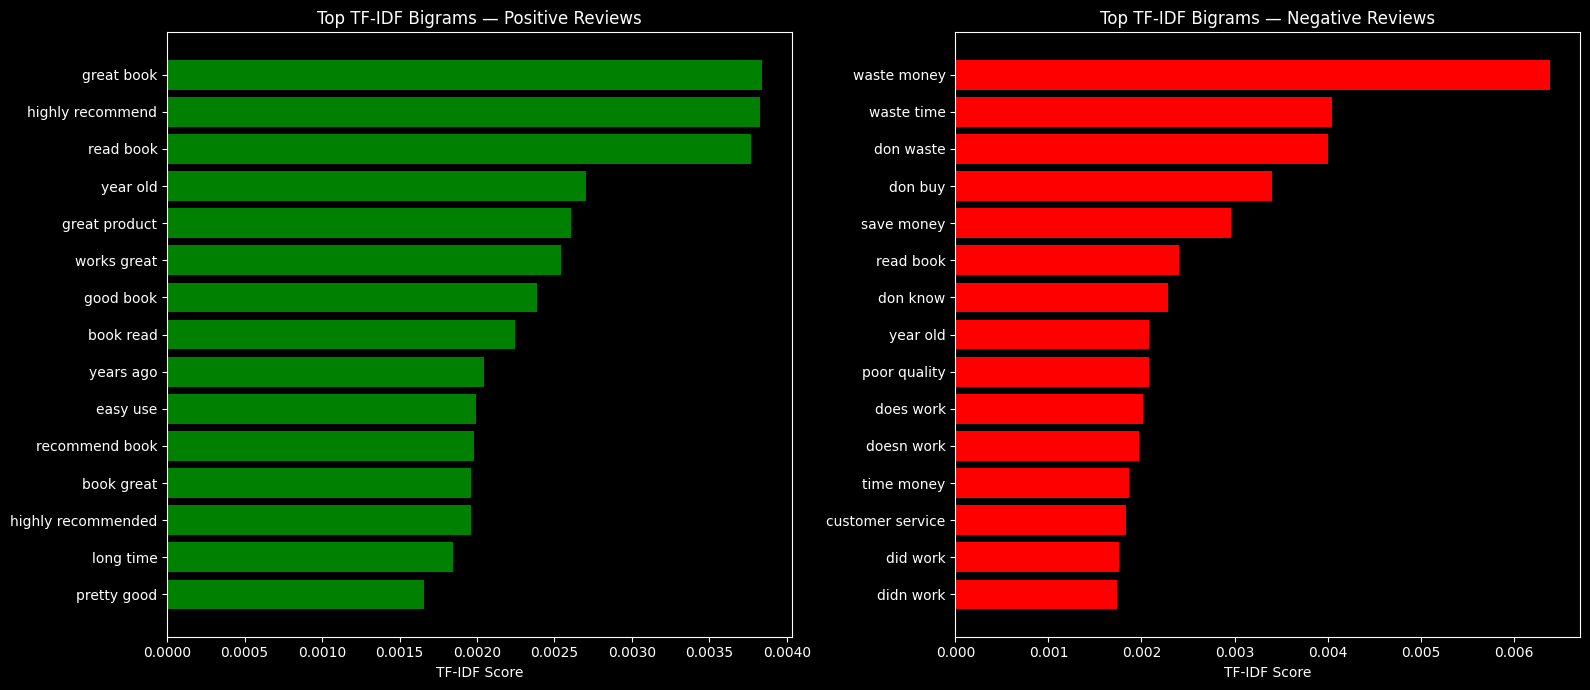

In [11]:
# EDA: Top TF-IDF bigrams by sentiment class
# -----------------------------------------

# This analysis identifies the most relevant bigram patterns that differentiate
# positive vs negative reviews. Bigrams capture context better than single words,
# e.g., "not good", "highly recommend", "poor quality", etc.

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# Split by class
positive = df[df["label"] == 2]["text_full"]
negative = df[df["label"] == 1]["text_full"]

# TF-IDF Vectorizer for bigrams only
vectorizer = TfidfVectorizer(
    ngram_range=(2, 2),       # Only bigrams
    stop_words="english",
    min_df=5,                 # Remove very rare bigrams
    max_df=0.90               # Remove overly common neutral phrases
)

# Fit on full dataset, transform per class
vectorizer.fit(df["text_full"])
pos_vec = vectorizer.transform(positive)
neg_vec = vectorizer.transform(negative)

# Convert to DataFrame
feature_names = vectorizer.get_feature_names_out()

pos_scores = pd.DataFrame(pos_vec.mean(axis=0).A1, index=feature_names, columns=["score"]) \
    .sort_values("score", ascending=False)

neg_scores = pd.DataFrame(neg_vec.mean(axis=0).A1, index=feature_names, columns=["score"]) \
    .sort_values("score", ascending=False)

print("\nTop Positive Bigrams:")
print(pos_scores.head(20))

print("\nTop Negative Bigrams:")
print(neg_scores.head(20))

top_n = 15

# Reverse order so highest values appear at the top
pos_plot = pos_scores.head(top_n).iloc[::-1]
neg_plot = neg_scores.head(top_n).iloc[::-1]

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

axes[0].barh(pos_plot.index, pos_plot.score, color="green")
axes[0].set_title("Top TF-IDF Bigrams — Positive Reviews")
axes[0].set_xlabel("TF-IDF Score")

axes[1].barh(neg_plot.index, neg_plot.score, color="red")
axes[1].set_title("Top TF-IDF Bigrams — Negative Reviews")
axes[1].set_xlabel("TF-IDF Score")

plt.tight_layout()
plt.show()


=== Top discriminative terms for POSITIVE reviews ===
                feature         chi2        p_value
11616             great  2657.057416   0.000000e+00
28709             waste  1817.928434   0.000000e+00
17239             money  1453.086978   0.000000e+00
16073              love  1354.587999  1.551207e-296
9124          excellent  1242.527999  3.490691e-272
28714       waste money  1162.620443  8.110111e-255
2400               best  1113.201230  4.463631e-244
29550             worst  1071.798105  4.451209e-235
20007              poor  1053.919815  3.422513e-231
7462       disappointed   925.356282  3.018241e-203
3627             boring   914.027131  8.760259e-201
1959                bad   879.884876  2.315591e-193
26158          terrible   829.718589  1.865737e-182
8451               easy   818.198618  5.962235e-180
29264         wonderful   807.573649  1.217372e-177
12895          horrible   796.630001  2.915826e-175
7501      disappointing   754.979843  3.315959e-166
1879      

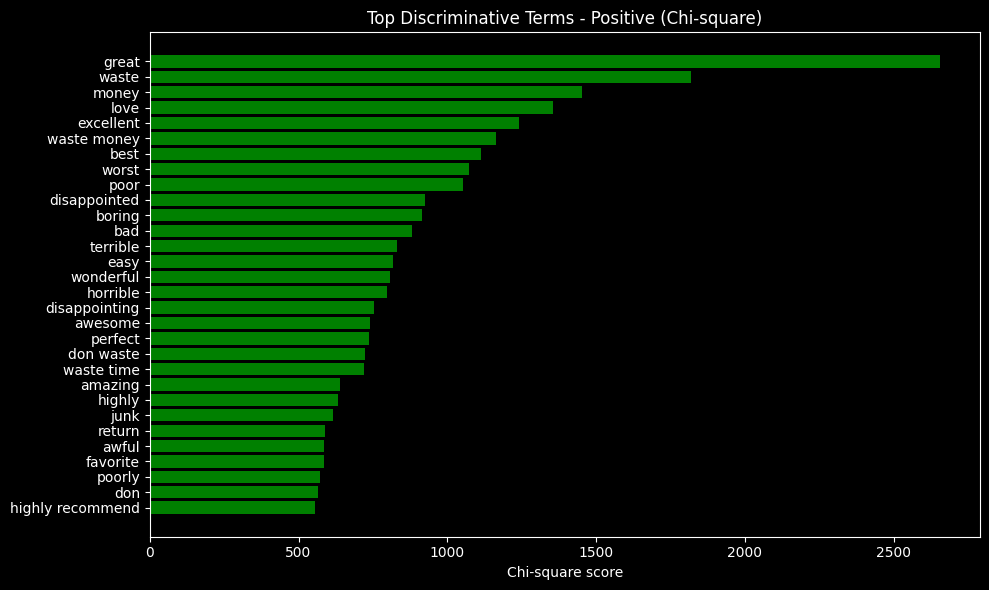

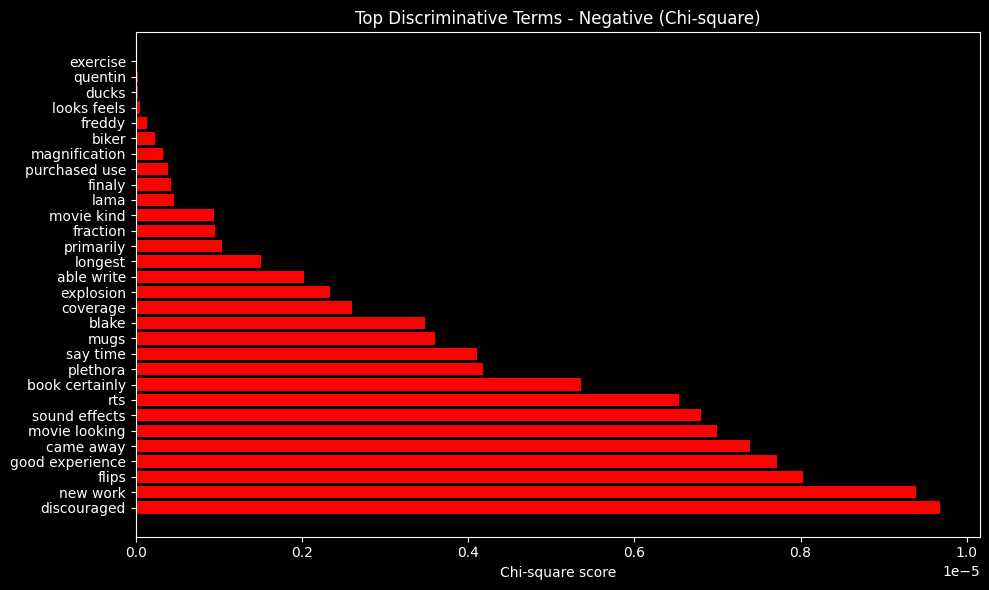

In [12]:
# EDA: Feature Importance via Chi-Square Test
# -----------------------------------------

# This analysis identifies which words or phrases (unigrams and bigrams)
# are most statistically associated with positive or negative sentiment
# using the Chi-square test of independence.


# Load dataset
df = df.dropna(subset=["text_full"])

# Convert labels to 0/1 for consistency
df["label_binary"] = df["label"].map({1: 0, 2: 1})


# Create TF-IDF features
vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),      # captures unigrams + bigrams
    stop_words="english",
    min_df=5,                # remove extremely rare terms
    max_features=30000       # keep it manageable
)

X = vectorizer.fit_transform(df["text_full"])
y = df["label_binary"]


# Compute chi-square scores
chi_scores, p_values = chi2(X, y)

feature_names = np.array(vectorizer.get_feature_names_out())
scores_df = pd.DataFrame({
    "feature": feature_names,
    "chi2": chi_scores,
    "p_value": p_values
}).sort_values("chi2", ascending=False)


# Top discriminative terms
top_n = 30

top_positive = scores_df.head(top_n)
top_negative = scores_df.tail(top_n)  # low chi values can correlate with opposite class

print("=== Top discriminative terms for POSITIVE reviews ===")
print(top_positive)

print("\n=== Top discriminative terms for NEGATIVE reviews ===")
print(top_negative)



# Plot top positive terms
plt.figure(figsize=(10,6))
plt.barh(top_positive["feature"].iloc[::-1], top_positive["chi2"].iloc[::-1], color="green")
plt.title("Top Discriminative Terms - Positive (Chi-square)")
plt.xlabel("Chi-square score")
plt.tight_layout()
plt.show()


# Plot top negative terms
plt.figure(figsize=(10,6))
plt.barh(top_negative["feature"], top_negative["chi2"], color="red")
plt.title("Top Discriminative Terms - Negative (Chi-square)")
plt.xlabel("Chi-square score")
plt.tight_layout()
plt.show()
